Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [54]:
NAME = "Umar Momen"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Extras

Put all of your extra work in here. Feel free to save figures to use when completing Part 4.

In [55]:
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

In [56]:
# Run this cell to load the data. 
data_file = Path("./", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")

In [57]:
test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])

In [ ]:
###checking for outliers in fare and tolls

In [58]:
min(test_df['fare_amount'])

-93.3

In [59]:
min(test_df['tolls_amount'])

0.0

In [ ]:
#checking for geography outliers

In [60]:
print(min(test_df['pickup_latitude']))
print(max(test_df['dropoff_longitude']))


0.0
0.0


In [61]:
print(min(test_df['improvement_surcharge']))
print(sum(test_df['improvement_surcharge'] < 0))

-0.3
6


In [62]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [63]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [64]:
###MODEL

In [65]:
def process_data_fm(data, test=False):
    
    #cleaning negatives
    data['fare_amount'] = np.abs(data["fare_amount"])
    data['trip_distance'] = np.abs(data["trip_distance"])
    
    #cleaning Latitude and Longitude errors
    data['pickup_longitude'] = data['pickup_longitude'].replace(0, np.mean(data.loc[data['pickup_longitude'] != 0, 'pickup_longitude']))
    data['pickup_latitude'] = data['pickup_latitude'].replace(0, np.mean(data.loc[data['pickup_latitude'] != 0, 'pickup_latitude']))
    data['dropoff_longitude'] = data['dropoff_longitude'].replace(0, np.mean(data.loc[data['dropoff_longitude'] != 0, 'dropoff_longitude']))
    data['dropoff_latitude'] = data['dropoff_latitude'].replace(0, np.mean(data.loc[data['dropoff_latitude'] != 0, 'dropoff_latitude']))

    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
#               'pickup_longitude',  
#               'pickup_latitude',     <--- features that didn't work
#               'dropoff_longitude', 
#               'dropoff_latitude',
#               'manhattan',
#               'bearing',
#              'week_hour',
              'hour',
              'trip_distance',
              'fare_amount',
              'tolls_amount',
              #'mta_tax',
             # 'improvement_surcharge'
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y


In [66]:
# Train
X_train, y_train = process_data_fm(train_df)
X_val, y_val = process_data_fm(val_df)
final_model = lm.LinearRegression(fit_intercept=True)
final_model.fit(X_train, y_train)

# Predict
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [68]:
print("Validation Error: ", mae(y_val_pred, y_val))

Validation Error:  148.930580114


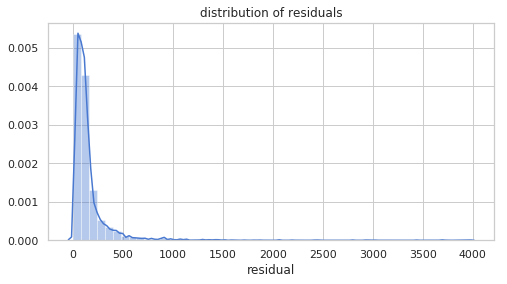

In [69]:
plt.figure(figsize=(8,4))
sns.distplot(np.abs(y_val - y_val_pred))
plt.xlabel('residual')
plt.title('distribution of residuals');

In [ ]:
### residuals have decreased significantly

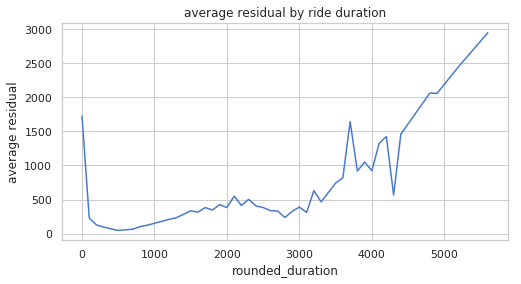

In [70]:
val_residual = X_val.copy()
val_residual['duration'] = y_val
val_residual['rounded_duration'] = np.around(y_val, -2)
val_residual['residual'] = np.abs(y_val - y_val_pred)
tmp = val_residual.groupby('rounded_duration').mean()
plt.figure(figsize=(8,4))
tmp['residual'].plot()
plt.ylabel('average residual')
plt.title('average residual by ride duration');

In [ ]:
#it seems that longer trips are hard to predict accurately, but the shorter trip resuduals have gone down a lot

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**